In [1]:
! pip3 install matplotlib
! pip3 install geopandas 
! pip3 install Shapely 
! pip3 install folium 
! pip3 install rasterio
! pip3 install sentinelsat 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 23.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 31.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.7/48.7 KB 3.1 MB/s eta 0:00:00


In [2]:
!git clone https://github.com/SaladBreaker/SateliteForestDetection.git
!mv -v ./SateliteForestDetection/* ./ 
!rm -rf ./SateliteForestDetection/


Cloning into 'SateliteForestDetection'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 50 (delta 13), reused 39 (delta 7), pack-reused 0
Unpacking objects: 100% (50/50), done.
renamed './SateliteForestDetection/install.ipynb' -> './install.ipynb'
renamed './SateliteForestDetection/LICENSE' -> './LICENSE'
renamed './SateliteForestDetection/poetry.lock' -> './poetry.lock'
renamed './SateliteForestDetection/poetry.toml' -> './poetry.toml'
renamed './SateliteForestDetection/pyproject.toml' -> './pyproject.toml'
renamed './SateliteForestDetection/README.md' -> './README.md'
renamed './SateliteForestDetection/Satelite.ipynb' -> './Satelite.ipynb'
renamed './SateliteForestDetection/src' -> './src'
renamed './SateliteForestDetection/utils.py' -> './utils.py'


In [3]:
!rm src/settings/credentials.py
!mkdir src/settings
!echo 'AUTH = {"USERNAME": "SaladBrk", "PASSWORD": "4wlzkmvMLn3TJA5G"}' > src/settings/credentials.py

rm: cannot remove 'src/settings/credentials.py': No such file or directory


In [4]:
from sentinelsat import SentinelAPI
from shapely.geometry import Point, Polygon
import dask 
import matplotlib.pyplot as plt
import zipfile
import geopandas as gpd
import threading
import folium
import rasterio as rio
import os

import numpy as np
np.seterr(divide='ignore', invalid='ignore')

from src.dumper import Santinel2Dumper
from src.manager import Santinel2Manager
from src.misc import MapManager


REDOWNLOAD = True

DOWNLOAD_PATH="./satelite_datasets"
RESULTS_PATH = "./satelite_results"



## Set and view the chose target data

In [5]:
# create target poligon
# coordonates of forest near Medias,Sibiu
TARGET_SHAPE = [
    (24.197322, 46.202205), 
    (24.220021, 46.194055), 
    (24.261777, 46.179938),  
    (24.257313, 46.147835),
    (24.209952, 46.154057),
    (24.211586, 46.170317),
    (24.190559, 46.179364)
]


# display map
MapManager.get_map_with_target(TARGET_SHAPE)


## See what data is available 

In [6]:
# get query results 
dumper = Santinel2Dumper()

products_gdf = dumper.get_products_from_query(
    Polygon(TARGET_SHAPE),
    date_range=("20220930", "20230130")
)

products_gdf_sorted = products_gdf.sort_values(['beginposition'], ascending=[True])
products_gdf_sorted.columns

Index(['title', 'link', 'link_alternative', 'link_icon', 'summary', 'ondemand',
       'generationdate', 'beginposition', 'endposition', 'ingestiondate',
       'orbitnumber', 'relativeorbitnumber', 'illuminationazimuthangle',
       'illuminationzenithangle', 'vegetationpercentage',
       'notvegetatedpercentage', 'waterpercentage', 'unclassifiedpercentage',
       'mediumprobacloudspercentage', 'highprobacloudspercentage',
       'snowicepercentage', 'cloudcoverpercentage', 'level1cpdiidentifier',
       'format', 'processingbaseline', 'platformname', 'filename',
       'instrumentname', 'instrumentshortname', 'size', 's2datatakeid',
       'producttype', 'platformidentifier', 'orbitdirection',
       'platformserialidentifier', 'processinglevel', 'datastripidentifier',
       'granuleidentifier', 'identifier', 'uuid', 'geometry'],
      dtype='object')

## Targets

In [7]:
# look for a close vegetationpercentage
targets = products_gdf_sorted.iloc[[0, -1]]
targets[["title","beginposition","summary","vegetationpercentage"]]

,title,beginposition,summary,vegetationpercentage
db2fcd50-9af1-4fa9-8ecc-b22ec9557746,S2A_MSIL2A_20221020T092031_N0400_R093_T34TGS_2...,2022-10-20 09:20:31.024,"Date: 2022-10-20T09:20:31.024Z, Instrument: MS...",66.288102
9e1056a6-31d0-464f-accc-4712453264f3,S2A_MSIL2A_20221129T092331_N0400_R093_T34TGS_2...,2022-11-29 09:23:31.024,"Date: 2022-11-29T09:23:31.024Z, Instrument: MS...",26.450461


## Download the query results

In [8]:
if REDOWNLOAD:
    dumper.download_satelite_data(targets.iloc[ 0].uuid,DOWNLOAD_PATH)
    dumper.download_satelite_data(targets.iloc[-1].uuid,DOWNLOAD_PATH)
else:
    print("Redownload is set to false")


MD5 checksumming:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

MD5 checksumming:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

## Assamble data from old imagery

In [9]:
manager_old = Santinel2Manager(f"{DOWNLOAD_PATH}/{targets.iloc[0].title}.zip")

/usr/local/lib/python3.8/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [36]:
%%time
THRESHOLD = .3
_meta = manager_old.get_R10m_reader().meta
old_img_NDVI = manager_old.get_NDVI()
old_img_NDVI_veg = manager_old.get_NDVI_vegetation_only(THRESHOLD)

CPU times: user 4min, sys: 4.77 s, total: 4min 5s
Wall time: 3min 3s


In [37]:
old_img_NDVI_veg.shape

(10980, 10980)

In [39]:
!mkdir -p ./satelite_results/S2A_MSIL2A_20221020T092031_N0400_R093_T34TGS_20221020T135654/


In [40]:
!touch ./satelite_results/S2A_MSIL2A_20221020T092031_N0400_R093_T34TGS_20221020T135654/NDVI.tiff


In [41]:
%%time

manager_old.write_image(old_img_NDVI,_meta,f"{RESULTS_PATH}/{targets.iloc[0].title}/NDVI.tiff")
manager_old.write_image(old_img_NDVI_veg,_meta,f"{RESULTS_PATH}/{targets.iloc[0].title}/NDVI_veg.tiff")



ERROR:Santinel2Manager:Creation of the directory ./satelite_results/S2A_MSIL2A_20221020T092031_N0400_R093_T34TGS_20221020T135654 failed
ERROR:Santinel2Manager:Creation of the directory ./satelite_results/S2A_MSIL2A_20221020T092031_N0400_R093_T34TGS_20221020T135654 failed


CPU times: user 1.64 s, sys: 2.79 s, total: 4.43 s
Wall time: 5.62 s


In [42]:
%%time

manager_old.crop_image(
    f"{RESULTS_PATH}/{targets.iloc[0].title}/NDVI.tiff",
    f"{RESULTS_PATH}/{targets.iloc[0].title}/cropped_NDVI.tif",
    Polygon(TARGET_SHAPE)
)
manager_old.crop_image(
    f"{RESULTS_PATH}/{targets.iloc[0].title}/NDVI_veg.tiff",
    f"{RESULTS_PATH}/{targets.iloc[0].title}/cropped_NDVI_veg.tif",
    Polygon(TARGET_SHAPE)
)

CPU times: user 89.1 ms, sys: 43 ms, total: 132 ms
Wall time: 136 ms


/usr/local/lib/python3.8/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.8/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


## Assamble data from new imagery

In [43]:
!mkdir -p ./satelite_results/S2A_MSIL2A_20221020T092031_N0400_R093_T34TGS_20221129T140804/
!touch ./satelite_results/S2A_MSIL2A_20221020T092031_N0400_R093_T34TGS_20221129T140804/NDVI.tiff

In [44]:
manager_new = Santinel2Manager(f"{DOWNLOAD_PATH}/{targets.iloc[-1].title}.zip")

/usr/local/lib/python3.8/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [45]:
%%time

_meta = manager_new.get_R10m_reader().meta
new_img_NDVI = manager_new.get_NDVI()
new_img_NDVI_veg = manager_new.get_NDVI_vegetation_only(THRESHOLD)

CPU times: user 3min 51s, sys: 3.46 s, total: 3min 55s
Wall time: 2min 47s


In [46]:
%%time

manager_new.write_image(new_img_NDVI,_meta,f"{RESULTS_PATH}/{targets.iloc[-1].title}/NDVI.tiff")
manager_new.write_image(new_img_NDVI_veg,_meta,f"{RESULTS_PATH}/{targets.iloc[-1].title}/NDVI_veg.tiff")

ERROR:Santinel2Manager:Creation of the directory ./satelite_results/S2A_MSIL2A_20221129T092331_N0400_R093_T34TGS_20221129T140804 failed
ERROR:Santinel2Manager:Creation of the directory ./satelite_results/S2A_MSIL2A_20221129T092331_N0400_R093_T34TGS_20221129T140804 failed


CPU times: user 1.32 s, sys: 2.35 s, total: 3.67 s
Wall time: 4.79 s


In [47]:
%%time

manager_new.crop_image(
    f"{RESULTS_PATH}/{targets.iloc[-1].title}/NDVI.tiff",
    f"{RESULTS_PATH}/{targets.iloc[-1].title}/cropped_NDVI.tif",
    Polygon(TARGET_SHAPE)
)
manager_new.crop_image(
    f"{RESULTS_PATH}/{targets.iloc[-1].title}/NDVI_veg.tiff",
    f"{RESULTS_PATH}/{targets.iloc[-1].title}/cropped_NDVI_veg.tif",
    Polygon(TARGET_SHAPE)
)

CPU times: user 85 ms, sys: 36 ms, total: 121 ms
Wall time: 136 ms


/usr/local/lib/python3.8/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.8/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


## Compare old and new vegetation index on target

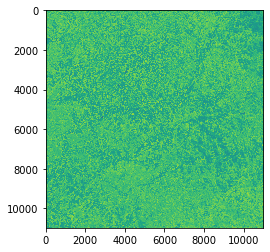

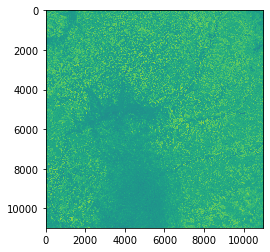

In [48]:

from matplotlib import pyplot as plt
plt.imshow(old_img_NDVI, interpolation='nearest')
plt.show()

plt.imshow(new_img_NDVI, interpolation='nearest')
plt.show()

In [49]:
with rio.open(f"{RESULTS_PATH}/{targets.iloc[-1].title}/cropped_NDVI_veg.tif") as f:
    veg_new = f.read()

with rio.open(f"{RESULTS_PATH}/{targets.iloc[0].title}/cropped_NDVI_veg.tif") as f:
    veg_old = f.read()

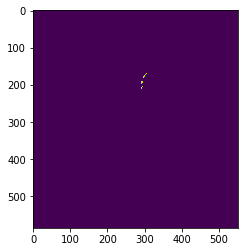

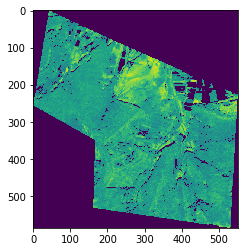

In [50]:
plt.imshow(veg_new[0], interpolation='nearest')
plt.show()

plt.imshow(veg_old[0], interpolation='nearest')
plt.show()